In [3]:
# ===========================================
# 🧩 SNIPPET 1: Imports and Preprocessing
# ===========================================

import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)

from datasets import Dataset
from transformers import (
    AutoTokenizer, AutoModelForSequenceClassification,
    TrainingArguments, Trainer
)
import torch
from scipy.special import softmax
import evaluate

# ==============================
# 1️⃣ Load Dataset
# ==============================
df = pd.read_excel(r"Training Dataset.xlsx")

# Clean structure
df = df[df["Category"] != "Category"].copy()
df.drop(columns=[c for c in df.columns if c.startswith("Unnamed")], inplace=True)
df.rename(columns={"Category": "Label", "Messages": "Text"}, inplace=True)
df.dropna(subset=["Text"], inplace=True)
df["Label"] = df["Label"].map({"Ham": 0, "Spam": 1}).astype(int)

# ==============================
# 2️⃣ Text Cleaning
# ==============================
def clean_text_for_transformer(text: str) -> str:
    text = re.sub(r"\d+", "", text)
    text = re.sub(r"\s+", " ", text)
    return text.strip()

df["Clean_Text"] = df["Text"].apply(clean_text_for_transformer)

# ==============================
# 3️⃣ Split Data
# ==============================
df_train_raw, df_test_raw = train_test_split(
    df[["Clean_Text", "Label"]].rename(columns={"Clean_Text": "text", "Label": "label"}),
    test_size=0.2, stratify=df["Label"], random_state=42
)

train_dataset = Dataset.from_pandas(df_train_raw.reset_index(drop=True))
test_dataset = Dataset.from_pandas(df_test_raw.reset_index(drop=True))

# ==============================
# 4️⃣ Common Metric Function
# ==============================
metric_f1 = evaluate.load("f1")

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=-1)
    f1 = metric_f1.compute(predictions=preds, references=labels, average="weighted")["f1"]
    acc = accuracy_score(labels, preds)
    prec = precision_score(labels, preds)
    rec = recall_score(labels, preds)
    return {"accuracy": acc, "precision": prec, "recall": rec, "f1": f1}

print("✅ Data loaded and preprocessed successfully!")


✅ Data loaded and preprocessed successfully!



🚀 Training MuRIL (google/muril-base-cased)


Map: 100%|██████████| 690/690 [00:00<00:00, 15277.46 examples/s]
c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\rohit\.cache\huggingface\hub\models--google--muril-base-cased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Some weights of BertForSe

Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.194214,0.963768,0.995074,0.946136,0.964007
2,No log,0.066577,0.986957,0.995261,0.983607,0.986980


c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 MuRIL Results:
Accuracy: 0.9870, Precision: 0.9953, Recall: 0.9836, F1: 0.9894

Classification Report:
               precision    recall  f1-score   support

           0     0.9739    0.9924    0.9831       263
           1     0.9953    0.9836    0.9894       427

    accuracy                         0.9870       690
   macro avg     0.9846    0.9880    0.9862       690
weighted avg     0.9871    0.9870    0.9870       690



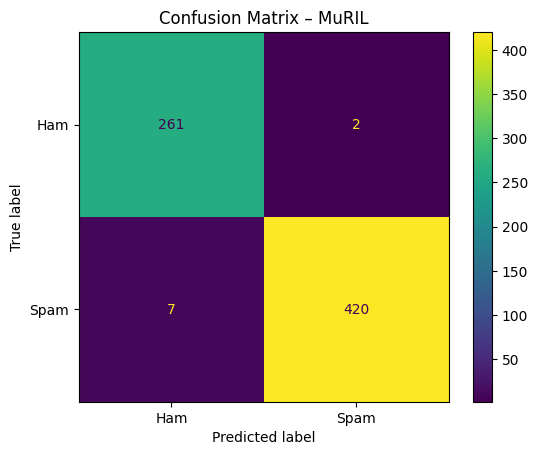

In [2]:
# ===========================================
# ⚙ SNIPPET 2: MuRIL Transformer Training
# ===========================================

MODEL_NAME = "google/muril-base-cased"
MODEL_LABEL = "MuRIL"

print(f"\n🚀 Training {MODEL_LABEL} ({MODEL_NAME})")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2, id2label={0:"Ham",1:"Spam"}, label2id={"Ham":0,"Spam":1}
)

training_args = TrainingArguments(
    output_dir=f"./results_{MODEL_LABEL}",
    num_train_epochs=2, per_device_train_batch_size=16, per_device_eval_batch_size=16,
    warmup_steps=100, weight_decay=0.01,
    eval_strategy="epoch", save_strategy="epoch",
    logging_dir=f"./logs_{MODEL_LABEL}", load_best_model_at_end=True,
    metric_for_best_model="f1", fp16=torch.cuda.is_available()
)

trainer = Trainer(
    model=model, args=training_args,
    train_dataset=tokenized_train, eval_dataset=tokenized_test,
    tokenizer=tokenizer, compute_metrics=compute_metrics
)

trainer.train()
results = trainer.predict(tokenized_test)

y_true = df_test_raw["label"].values
probs = softmax(results.predictions, axis=1)
y_pred = np.argmax(results.predictions, axis=1)

acc, prec, rec, f1 = (
    accuracy_score(y_true, y_pred),
    precision_score(y_true, y_pred),
    recall_score(y_true, y_pred),
    f1_score(y_true, y_pred),
)

print(f"\n📊 {MODEL_LABEL} Results:")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=["Ham","Spam"]).plot(cmap="viridis")
plt.title(f"Confusion Matrix – {MODEL_LABEL}")
plt.show()

muril_results = {"Model": MODEL_LABEL, "Accuracy":round(acc,4),"Precision":round(prec,4),
                 "Recall":round(rec,4),"F1 Score":round(f1,4)}

In [4]:
import pickle
with open("muril_model.pickle","wb") as f:
    pickle.dump(model,f)

In [1]:
import pickle

try:
    with open("muril_model.pickle", "rb") as f:
        obj = pickle.load(f)
    print("✅ Pickle file loaded successfully!")
    print("Object type:", type(obj))
except Exception as e:
    print("❌ Error loading pickle file:", e)

c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


✅ Pickle file loaded successfully!
Object type: <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>



🚀 Training IndicBERT (bert-base-multilingual-cased)


Map: 100%|██████████| 690/690 [00:00<00:00, 10949.94 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rohit\AppData\Local\Temp\ipykernel_25780\1043456671.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.012085,0.992754,1.000000,0.988290,0.992766
2,No log,0.000222,1.000000,1.000000,1.000000,1.000000


c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 IndicBERT Results:
Accuracy: 1.0000, Precision: 1.0000, Recall: 1.0000, F1: 1.0000

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    1.0000    1.0000       263
           1     1.0000    1.0000    1.0000       427

    accuracy                         1.0000       690
   macro avg     1.0000    1.0000    1.0000       690
weighted avg     1.0000    1.0000    1.0000       690



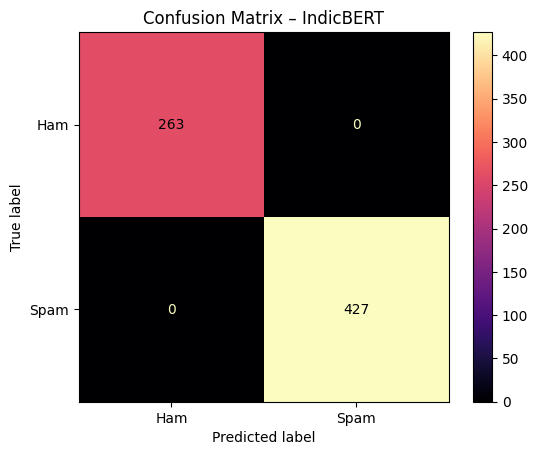

In [9]:
# ===========================================
# 🟣 SNIPPET 3: IndicBERT Transformer Training
# ===========================================

MODEL_NAME = "bert-base-multilingual-cased"
MODEL_LABEL = "IndicBERT"

print(f"\n🚀 Training {MODEL_LABEL} ({MODEL_NAME})")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2, id2label={0:"Ham",1:"Spam"}, label2id={"Ham":0,"Spam":1}
)

training_args = TrainingArguments(
    output_dir=f"./results_{MODEL_LABEL}",
    num_train_epochs=2, per_device_train_batch_size=16, per_device_eval_batch_size=16,
    warmup_steps=100, weight_decay=0.01,
    eval_strategy="epoch", save_strategy="epoch",
    logging_dir=f"./logs_{MODEL_LABEL}", load_best_model_at_end=True,
    metric_for_best_model="f1", fp16=torch.cuda.is_available()
)

trainer = Trainer(
    model=model, args=training_args,
    train_dataset=tokenized_train, eval_dataset=tokenized_test,
    tokenizer=tokenizer, compute_metrics=compute_metrics
)

trainer.train()
results = trainer.predict(tokenized_test)

y_true = df_test_raw["label"].values
probs = softmax(results.predictions, axis=1)
y_pred = np.argmax(results.predictions, axis=1)

acc, prec, rec, f1 = (
    accuracy_score(y_true, y_pred),
    precision_score(y_true, y_pred),
    recall_score(y_true, y_pred),
    f1_score(y_true, y_pred),
)

print(f"\n📊 {MODEL_LABEL} Results:")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=["Ham","Spam"]).plot(cmap="magma")
plt.title(f"Confusion Matrix – {MODEL_LABEL}")
plt.show()

indicbert_results = {"Model": MODEL_LABEL, "Accuracy":round(acc,4),"Precision":round(prec,4),
                     "Recall":round(rec,4),"F1 Score":round(f1,4)}

In [ ]:
import pickle
with open("indicBert_model.pickle","wb") as f:
    pickle.dump(model,f)

In [11]:
import pickle

try:
    with open("indicBert_model.pickle", "rb") as f:
        obj = pickle.load(f)
    print("✅ Pickle file loaded successfully!")
    print("Object type:", type(obj))
except Exception as e:
    print("❌ Error loading pickle file:", e)

✅ Pickle file loaded successfully!
Object type: <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>



🚀 Training mBERT (bert-base-multilingual-cased)


Map: 100%|██████████| 690/690 [00:00<00:00, 15135.40 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
C:\Users\rohit\AppData\Local\Temp\ipykernel_25780\751443293.py:30: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,No log,0.015231,0.995652,1.000000,0.992974,0.995657
2,No log,0.012108,0.998551,1.000000,0.997658,0.998551


c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)
c:\Users\rohit\AppData\Local\Programs\Python\Python312\Lib\site-packages\torch\utils\data\dataloader.py:668: UserWarning: 'pin_memory' argument is set as true but no accelerator is found, then device pinned memory won't be used.
  warnings.warn(warn_msg)



📊 mBERT Results:
Accuracy: 0.9986, Precision: 1.0000, Recall: 0.9977, F1: 0.9988

Classification Report:
               precision    recall  f1-score   support

           0     0.9962    1.0000    0.9981       263
           1     1.0000    0.9977    0.9988       427

    accuracy                         0.9986       690
   macro avg     0.9981    0.9988    0.9985       690
weighted avg     0.9986    0.9986    0.9986       690



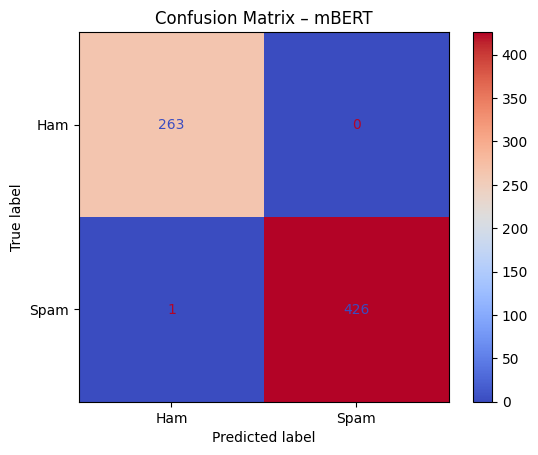

In [12]:
# ===========================================
# 🌍 SNIPPET 4: mBERT Transformer Training
# ===========================================

MODEL_NAME = "bert-base-multilingual-cased"
MODEL_LABEL = "mBERT"

print(f"\n🚀 Training {MODEL_LABEL} ({MODEL_NAME})")
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

def tokenize_function(examples):
    return tokenizer(examples["text"], truncation=True, padding="max_length", max_length=128)

tokenized_train = train_dataset.map(tokenize_function, batched=True)
tokenized_test = test_dataset.map(tokenize_function, batched=True)

model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME, num_labels=2, id2label={0:"Ham",1:"Spam"}, label2id={"Ham":0,"Spam":1}
)

training_args = TrainingArguments(
    output_dir=f"./results_{MODEL_LABEL}",
    num_train_epochs=2, per_device_train_batch_size=16, per_device_eval_batch_size=16,
    warmup_steps=100, weight_decay=0.01,
    eval_strategy="epoch", save_strategy="epoch",
    logging_dir=f"./logs_{MODEL_LABEL}", load_best_model_at_end=True,
    metric_for_best_model="f1", fp16=torch.cuda.is_available()
)

trainer = Trainer(
    model=model, args=training_args,
    train_dataset=tokenized_train, eval_dataset=tokenized_test,
    tokenizer=tokenizer, compute_metrics=compute_metrics
)

trainer.train()
results = trainer.predict(tokenized_test)

y_true = df_test_raw["label"].values
probs = softmax(results.predictions, axis=1)
y_pred = np.argmax(results.predictions, axis=1)

acc, prec, rec, f1 = (
    accuracy_score(y_true, y_pred),
    precision_score(y_true, y_pred),
    recall_score(y_true, y_pred),
    f1_score(y_true, y_pred),
)

print(f"\n📊 {MODEL_LABEL} Results:")
print(f"Accuracy: {acc:.4f}, Precision: {prec:.4f}, Recall: {rec:.4f}, F1: {f1:.4f}")
print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=4))

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred), display_labels=["Ham","Spam"]).plot(cmap="coolwarm")
plt.title(f"Confusion Matrix – {MODEL_LABEL}")
plt.show()

mbert_results = {"Model": MODEL_LABEL, "Accuracy":round(acc,4),"Precision":round(prec,4),
                 "Recall":round(rec,4),"F1 Score":round(f1,4)}

In [13]:
import pickle
with open("mBert_model.pickle","wb") as f:
    pickle.dump(model,f)

In [14]:
import pickle

try:
    with open("mBert_model.pickle", "rb") as f:
        obj = pickle.load(f)
    print("✅ Pickle file loaded successfully!")
    print("Object type:", type(obj))
except Exception as e:
    print("❌ Error loading pickle file:", e)

✅ Pickle file loaded successfully!
Object type: <class 'transformers.models.bert.modeling_bert.BertForSequenceClassification'>
